In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from preprocessing import data_collection, data_cleansing, log_transformation, differencing, linear_regression, seasonal_decompose_ts
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

We are going to pull the hourly price of Tesla from the previous year

In [2]:
stock_symbol = 'TSLA'
data = data_collection(stock_symbol, 365, '1h')

 Let us clean and check the data

In [3]:
data_clean = data_cleansing(data)
data_clean.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-04-25 09:30:00-04:00,159.820007,162.279999,158.750000,161.500000,35029014,0.0,0.0
2023-04-25 10:30:00-04:00,161.490005,163.470001,160.600006,163.080002,24652826,0.0,0.0
2023-04-25 11:30:00-04:00,163.059998,163.449997,162.046997,162.949997,14678457,0.0,0.0
2023-04-25 12:30:00-04:00,163.007996,163.199997,161.940002,162.690002,12462001,0.0,0.0
2023-04-25 13:30:00-04:00,162.694595,162.949997,161.199997,161.679993,11710833,0.0,0.0
2023-04-25 14:30:00-04:00,161.679993,162.610001,161.520004,161.589996,12157961,0.0,0.0
2023-04-25 15:30:00-04:00,161.580002,161.820007,160.500000,160.699997,7596443,0.0,0.0
2023-04-26 09:30:00-04:00,160.289993,160.669998,153.210007,154.370697,47684737,0.0,0.0
2023-04-26 10:30:00-04:00,154.339996,156.380005,153.919998,154.850006,25632615,0.0,0.0


Below shows the stock closing price with SMA

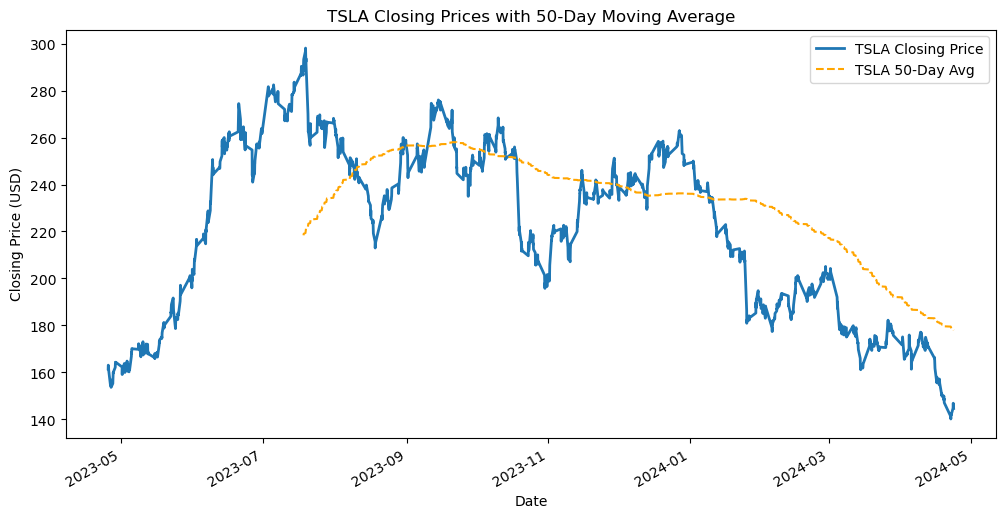

In [4]:
window = 400
plt.figure(figsize=(12, 6))
data_clean['Close'].plot(label=f'{stock_symbol} Closing Price', linewidth=2)
data_clean['Close'].rolling(window=window).mean().plot(label=f'{stock_symbol} 50-Day Avg', linestyle='--', color='orange')
plt.title(f'{stock_symbol} Closing Prices with 50-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()

Before applying models like ARIMA, we should check if the time series is stationary

In [5]:
# Check for stationarity using ADF test

result = adfuller(data_clean['Close'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -1.0858350841863202
p-value: 0.7206875272782803
Critical Values:
	1%: -3.4340965268715795
	5%: -2.863194882895319
	10%: -2.5676510108577832


The p-value suggests that the time series is non-stationary. Since ARIMA assumes a linear relationship, if the time series is non-stationary, we should remove trends and seasonality from the data. Below we apply log transformation to remove trends from a time series:

In [6]:
log_transformation(data_clean)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-04-25 09:30:00-04:00,159.820007,162.279999,158.750000,5.084505,35029014,0.0,0.0
2023-04-25 10:30:00-04:00,161.490005,163.470001,160.600006,5.094241,24652826,0.0,0.0
2023-04-25 11:30:00-04:00,163.059998,163.449997,162.046997,5.093443,14678457,0.0,0.0
2023-04-25 12:30:00-04:00,163.007996,163.199997,161.940002,5.091847,12462001,0.0,0.0
2023-04-25 13:30:00-04:00,162.694595,162.949997,161.199997,5.085619,11710833,0.0,0.0
...,...,...,...,...,...,...,...
2024-04-23 11:30:00-04:00,145.650208,146.899994,144.520004,4.989615,11187740,0.0,0.0
2024-04-23 12:30:00-04:00,146.860001,147.250000,145.320007,4.981550,10735466,0.0,0.0
2024-04-23 13:30:00-04:00,145.699997,145.720001,145.000000,4.979588,8625956,0.0,0.0


We are going to use pmdarima.auto_arima that will automatically select a model with the best differencing order. So what we need to do here is to remove the trend from the data.

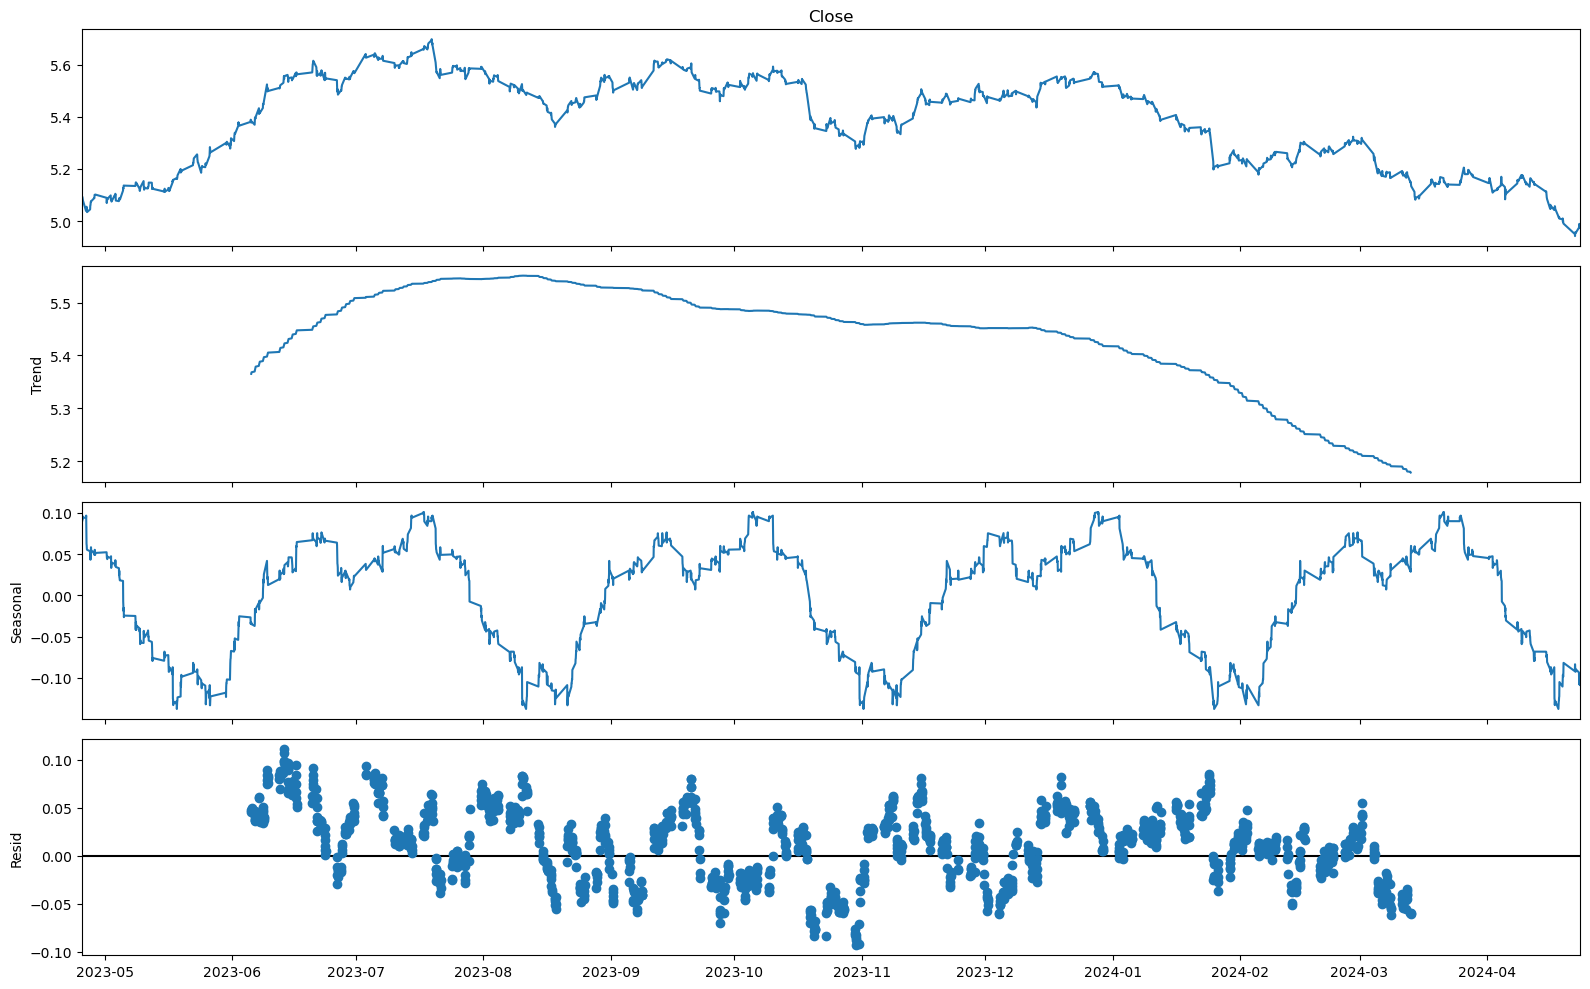

In [7]:
# Seasonal Decomposition
decomposition = seasonal_decompose(data_clean['Close'], model='additive', period=window)
plt.rcParams.update({'figure.figsize': (16, 10)})
decomposition.plot()
plt.show()

In [8]:
data_clean.to_csv('training_data.csv', index=True)